## Conversion to IonQ Native Gates

We are now in a position to transition to the native gates for IonQ. IonQ uses two single qubit gates:
$$
GPI(\phi) = \left ( \begin{matrix} 0 & e^{-i\phi}\\ e^{i\phi} & 0 \end{matrix}\right )
\qquad \text{and} \qquad GPI2(\phi) = \frac{1}{\sqrt{2}}\left ( \begin{matrix} 1 & -i e^{-i\phi}\\ -i e^{i\phi} & 1 \end{matrix}\right ).
$$
There is also a 2-qubit gate, the $MS(\phi_{0}, \phi_{1})$ gate; for now we note simply that $R_{xx}(\pi/2) = MS(0,0)$.

### Two Simplifying Calculations

Two quick calculations: $GPI2(\theta)^{\dagger} = GPI2(\theta + \pi)$ and $U(pi, \phi, -\phi) = GPI(\phi + \pi/2)$.

### Gate Translations

We translate the gates in our circuit as follows:
* $R_{y}(\pi/2) = GPI2(\pi/2)$
* $R_{y}(\pi) \equiv GPI(\pi/2) $ (Note that this is an equivalence, not an equality.)
* $R_{y}(-\pi/2) = GPI2(3\pi/2)$
* $U(\pi, 3\pi/4, -3\pi/4) = GPI(5\pi/4)$
* $U(\pi, \pi/4, -\pi/4) = GPI(3\pi/4)$
* $U(\pi, \pi/4 - \theta_{2}, \theta_{2} - \pi/4) = GPI(3\pi/4 - \theta_{2})$
* $U(3 \pi/2, \pi, -\pi) \equiv GPI2(\pi/2) $
* $R_{y}(2 \theta_{3}) = --- GPI(\pi/4) --- GPI(0) --- GPI2(\pi/2) --- GPI(\theta_{3}) --- GPI2(\pi/2) --- GPI(\pi/4) ---$

In the preparation component of the circuit we encounter a Hadamard gate along with a $R_{z}(\phi)$ gate. These are transpiled as follows:
* $H = --- GPI(0) --- GPI2(-\pi/2) --- = --- GPI2(\pi/2) --- GPI(0) ---$
* $R_{z}(\phi) = ---GPI(-\phi/2)---GPI(0)--- = --- GPI(0) --- GPI(\phi/2) ---$

Notice that $--- H --- R_{z}(\phi) --- \equiv --- GPI2(\pi/2) --- GPI(\phi/2) ---$ using the identities above.

Similarly, when we prepare to measure we have $--- R_{z}(-\phi) --- H --- \equiv --- GPI(\phi/2) --- GPI2(-\pi/2) ---$.

### Rotations

We recall that the IonQ angles are not expressed in terms of radians but in terms of turns. This means, for instance, that an angle of $\pi/2$ is expressed as $1/4$ turns. In general, a rotation through an angle $\theta $ corresponds to $\theta/2\pi$ turns.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

provider = IonQProvider("RmK0yNkCDPmoxCH12uQ4U67lpu9kFgik")
native_simulator = provider.get_backend("ionq_simulator", gateset="native")

In [2]:
def equatorial_prep(qc, phi):
    qc.append(GPI2Gate(1/4), [0])
    qc.append(GPIGate(phi/(4*np.pi)),[0])
    return qc

In [3]:
def equatorial_measurement_prep(qc, phi):
    qc.append(GPIGate(phi/(4*np.pi)), [0])
    qc.append(GPI2Gate(-1/4), [0])
    
    qc.append(GPIGate(phi/(4*np.pi)), [1])
    qc.append(GPI2Gate(-1/4), [1])
    
    qc.append(GPIGate(phi/(4*np.pi)), [2])
    qc.append(GPI2Gate(-1/4), [2])
    
    return qc

In [4]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/shots
        E = (out010 + out011 + out110 + out111)/shots
        A = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/shots
        E = (out001 + out000 + out101 + out100)/shots
        A = (out000 + out001 + out010 + out011)/shots
        
    return B,E,A 

In [5]:
def rxx_cloning(qc, theta2):
    
    #qc.ry(np.pi, 1) 
    qc.append(GPIGate(1/4), [1])
    
    #qc.rxx(np.pi/2, 1, 2) 
    qc.append(MSGate(0,0), [1,2])
    
    #qc.u(np.pi, 3*np.pi/4, -3*np.pi/4, 1)
    qc.append(GPIGate(5/8), [1])
    
    #qc.u(np.pi, np.pi/4 - theta2, theta2 - np.pi/4, 2)
    qc.append(GPIGate((3*np.pi/4 - theta2)/(2*np.pi)), [2])
    
    #qc.rxx(np.pi/2, 2, 1) 
    qc.append(MSGate(0,0), [2,1])
    
    #qc.ry(-np.pi/2, 2) 
    qc.append(GPI2Gate(3/4), [2])
    
    #qc.ry(2*theta2, 1) # theta2 =theta3 
    qc.append(GPIGate(1/8), [1])
    qc.append(GPIGate(0), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(theta2/(2*np.pi)), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(1/8), [1])
    
    #qc.ry(np.pi/2, 0) 
    qc.append(GPI2Gate(1/4), [0])
    
    #qc.rxx(np.pi/2, 0, 1) 
    qc.append(MSGate(0,0), [0,1])
    
    #qc.rxx(np.pi/2, 0, 2) 
    qc.append(MSGate(0,0), [0,2])
    
    #qc.u(3*np.pi/2, np.pi, -np.pi, 0)
    qc.append(GPI2Gate(1/4), [0])
    
    #qc.u(np.pi, np.pi/4, -np.pi/4, 1)
    qc.append(GPIGate(3/8), [1])
    
    #qc.rxx(np.pi/2, 1,0) 
    qc.append(MSGate(0,0), [1,0])
    
    #qc.ry(-np.pi/2, 1) 
    qc.append(GPI2Gate(3/4), [1])
    
    #qc.u(np.pi, np.pi/4, -np.pi/4, 2)
    qc.append(GPIGate(3/8), [2])
    
    #qc.rxx(np.pi/2, 2, 0) 
    qc.append(MSGate(0,0), [2,0])
    
    #qc.ry(-np.pi/2, 2) 
    qc.append(GPI2Gate(3/4), [2])
    
    return qc

In [6]:
def equatorial_cloner(theta2, phi):
    qc = QuantumCircuit(3,3)
    
    qc = equatorial_prep(qc, phi)
    qc.barrier()
    
    qc = rxx_cloning(qc, theta2)
    qc.barrier()
    
    qc = equatorial_measurement_prep(qc, phi)
    qc.barrier()
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    return qc

In [7]:
def phase_covariance(theta2, phi, shots):
        
    qc = equatorial_cloner(theta2, phi)
    
    shots = 1024 # number of samples used for statistics
    job = native_simulator.run(qc)
    probs = job.get_probabilities()
    
    out000 = job.result().get_counts().get("000")
    out001 = job.result().get_counts().get("001")
    out010 = job.result().get_counts().get("010")
    out011 = job.result().get_counts().get("011")
    out100 = job.result().get_counts().get("100")
    out101 = job.result().get_counts().get("101")
    out110 = job.result().get_counts().get("110")
    out111 = job.result().get_counts().get("111")

    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    B,E,A = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, 0, shots)
    
    return B,E,A, qc
    #return B,E,A

In [8]:
b,e,a, qc = phase_covariance(np.pi/8, 0, 1024)
print(b,e,a)
qc.draw()

0.8564453125 0.859375 0.7548828125


┌────────────┐┌────────┐ ░ ┌────────────┐                           »
q_0: ┤ Gpi2(0.25) ├┤ Gpi(0) ├─░─┤ Gpi2(0.25) ├───────────────────────────»
     └────────────┘└────────┘ ░ ├───────────┬┘┌──────────┐ ┌────────────┐»
q_1: ─────────────────────────░─┤ Gpi(0.25) ├─┤0         ├─┤ Gpi(0.625) ├»
                              ░ └───────────┘ │  Ms(0,0) │┌┴────────────┤»
q_2: ─────────────────────────░───────────────┤1         ├┤ Gpi(0.3125) ├»
                              ░               └──────────┘└─────────────┘»
c: 3/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«     ┌──────────┐┌────────────┐┌────────┐┌────────────┐┌─────────────┐»
«q_1: ┤1         ├┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├┤ Gpi(0.0625) ├»
«     │  Ms(0,0) │├────────────┤└────────┘└────────────┘└─────────────┘»
«q_2: ┤0         ├┤ Gpi2(0.75) ├───────────────────────────────────────»
«     └──────────┘└────────────┘                                       »
«c: 3/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                                 ┌──────────┐┌──────────┐┌────────────┐»
«q_0: ────────────────────────────┤0         ├┤0         ├┤ Gpi2(0.25) ├»
«     ┌────────────┐┌────────────┐│  Ms(0,0) ││          │├────────────┤»
«q_1: ┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤1         ├┤  Ms(0,0) ├┤ Gpi(0.375) ├»
«     └────────────┘└────────────┘└──────────┘│          │├────────────┤»
«q_2: ────────────────────────────────────────┤1         ├┤ Gpi(0.375) ├»
«                                             └──────────┘└────────────┘»
«c: 3/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌──────────┐              ┌──────────┐               ░ ┌────────┐»
«q_0: ┤1         ├──────────────┤1         ├───────────────░─┤ Gpi(0) ├»
«     │  Ms(0,0) │┌────────────┐│          │               ░ ├────────┤»
«q_1: ┤0         ├┤ Gpi2(0.75) ├┤  Ms(0,0) ├───────────────░─┤ Gpi(0) ├»
«     └──────────┘└────────────┘│          │┌────────────┐ ░ ├────────┤»
«q_2: ──────────────────────────┤0         ├┤ Gpi2(0.75) ├─░─┤ Gpi(0) ├»
«                               └──────────┘└────────────┘ ░ └────────┘»
«c: 3/═════════════════════════════════════════════════════════════════»
«                                                                      »
«     ┌─────────────┐ ░ ┌─┐      
«q_0: ┤ Gpi2(-0.25) ├─░─┤M├──────
«     ├─────────────┤ ░ └╥┘┌─┐   
«q_1: ┤ Gpi2(-0.25) ├─░──╫─┤M├───
«     ├─────────────┤ ░  ║ └╥┘┌─┐
«q_2: ┤ Gpi2(-0.25) ├─░──╫──╫─┤M├
«     └─────────────┘ ░  ║  ║ └╥┘
«c: 3/═══════════════════╩══╩══╩═
«                        0  1  2

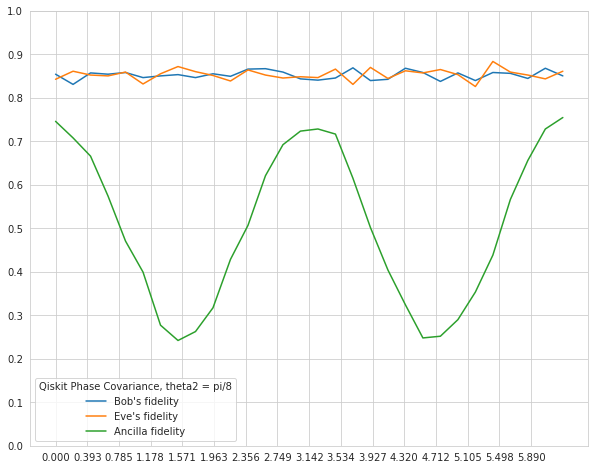

In [9]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a, qc = phase_covariance(np.pi/8, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="Qiskit Phase Covariance, theta2 = pi/8")
plt.show()